In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 

# start date April 13 2020 



In [2]:
df = pd.read_csv('california0.csv', sep=',', header=None)
date, active, new = np.array(df[0]), np.array(df[1]), np.array(df[2])

ac_new = np.stack([active, new], axis=1)
Max = np.max(ac_new, axis=0)
ac_new0 = ac_new/Max


timestep = 14 

Xorig = []
window = np.arange(0, timestep)

for i in range(date.size - timestep-1):
    day = ac_new0[window+i]
    Xorig.append(day)
    
Xorig = np.stack(Xorig)
Yorig = ac_new0[timestep+1:]

split = int(Xorig.shape[0]*0.9)

Xtrain, Xval = Xorig[0:split,:,:], Xorig[split:,:,:]
Ytrain, Yval = Yorig[0:split,:], Yorig[split:,:]
print(Xtrain.shape, Ytrain.shape)
print(Xval.shape, Yval.shape)

(103, 14, 2) (103, 2)
(12, 14, 2) (12, 2)


In [3]:
def build_model():
    In = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
    LSTM00 = LSTM(16, return_sequences=True)(In)
    LSTM01 = LSTM(16, return_sequences=True)(LSTM00)
    flat = Flatten()(LSTM01)
    Dense00 = Dense(16, activation='relu')(flat)
    output = Dense(Xtrain.shape[2],activation='sigmoid')(Dense00)
    
    model = keras.models.Model(inputs=[In], outputs=output)
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model

model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 2)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 14, 16)            1216      
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 16)            2112      
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                3600      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 6,962
Trainable params: 6,962
Non-trainable params: 0
___________________________________________________________

In [4]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
Epochs= 128
history = model.fit([Xtrain], Ytrain, verbose=1, epochs=Epochs, 
                   validation_data=([Xval], Yval), shuffle=False, callbacks=[callback],
                   batch_size=2)


Train on 103 samples, validate on 12 samples
Epoch 1/128
103/103 [==============================] - 6s 54ms/sample - loss: 0.0849 - mse: 0.0849 - val_loss: 0.1317 - val_mse: 0.1317
Epoch 2/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0737 - mse: 0.0737 - val_loss: 0.1312 - val_mse: 0.1312
Epoch 3/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0671 - mse: 0.0671 - val_loss: 0.1327 - val_mse: 0.1327
Epoch 4/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0452 - mse: 0.0452 - val_loss: 0.1116 - val_mse: 0.1116
Epoch 5/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0569 - val_mse: 0.0569
Epoch 6/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0397 - val_mse: 0.0397
Epoch 7/128
103/103 [==============================] - 1s 6ms/sample - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 8/1

Text(0.5, 1.0, 'MSE loss')

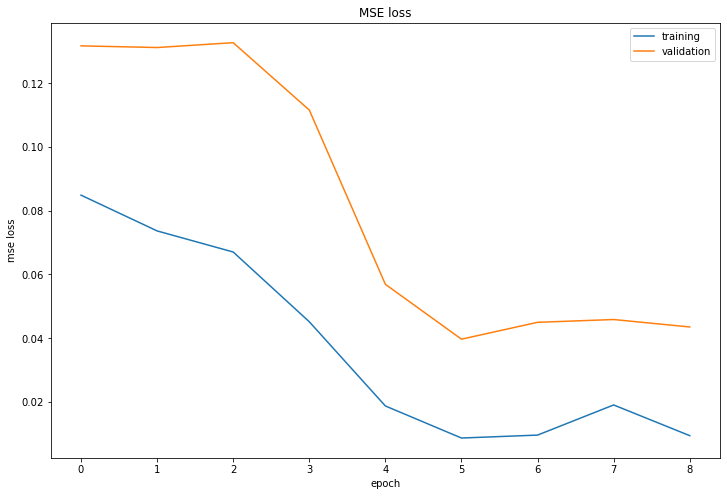

In [5]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [6]:
Xtotal = np.concatenate([Xtrain, Xval],axis=0)
Ytotal = np.concatenate([Ytrain, Yval],axis=0)

Ypredict = model.predict([Xtotal])*Max
Ytrue = Ytotal*Max

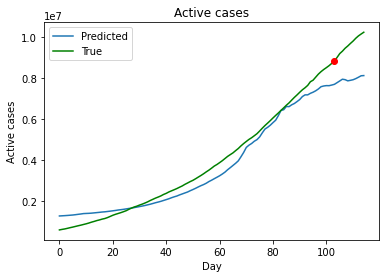

In [7]:
plt.plot(Ypredict[:,0], label='Predicted')
plt.plot(Ytrue[:,0], color='g', label='True')
plt.plot(Xtrain.shape[0], Ytrue[Xtrain.shape[0],0], 'ro')
plt.title('Active cases')
plt.ylabel('Active cases')
plt.xlabel('Day')
plt.legend()
plt.show()

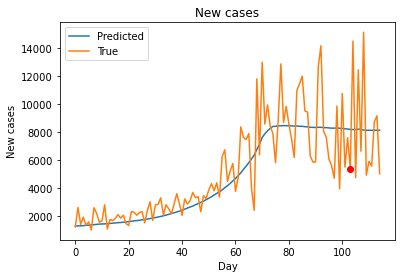

In [8]:
plt.plot(Ypredict[:,1], label='Predicted')
plt.plot(Ytrue[:,1], label='True')
plt.plot(Xtrain.shape[0], Ytrue[Xtrain.shape[0],1], 'ro')
plt.title('New cases')
plt.ylabel('New cases')
plt.xlabel('Day')
plt.legend()
plt.show()